In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# nltk -> natural language tool kit, the library we will use basic NLP functions

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score

In [2]:
data = pd.read_csv("data/samples/sample_20000.csv")

C:\Users\brzak\AppData\Local\Temp\ipykernel_11220\3922052023.py:1: DtypeWarning: Columns (0,2,4,11,20,22,33,35,36,41,80,81,82,84,85,89,92,95,96,100,101,113,114,121,123,130,134,135,136,144,147,155,162,164,168,169,172,173,174,175,176) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("data/samples/sample_20000.csv")


In [ ]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def preprocess(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    # Lemmatize each token
    # lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Stem each token
    
    lemmatized_tokens = [stemmer.stem(token) for token in tokens]
    # Join the tokens back into a string
    #return " ".join(lemmatized_tokens)
    return tokens


data["selftext_string"] = data["selftext"].astype(str)
data["selftext_preprocessed"] = data["selftext_string"].apply(preprocess)
print(data["selftext_preprocessed"].head(5).values)

# Ran too fucking long

KeyboardInterrupt: 

In [4]:
data_subset = data.sample(n=100, random_state=42)

def preprocess(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    # Lemmatize each token
    # lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Stem each token
    
    lemmatized_tokens = [stemmer.stem(token) for token in tokens]
    # Join the tokens back into a string
    #return " ".join(lemmatized_tokens)
    return tokens


data_subset["selftext_string"] = data_subset["selftext"].astype(str)
data_subset["selftext_preprocessed"] = data_subset["selftext_string"].apply(preprocess)
print(data_subset["selftext_preprocessed"].head(5).values)

[list(['my', 'ex', 'and', 'i', 'were', 'together', 'for', 'two', 'years', ',', 'and', 'she', 'is', 'my', 'first', 'lover', '.', 'we', 'had', 'a', 'tough', 'breakup', 'due', 'to', 'distance', 'and', 'my', 'parents', "'", 'objections', '.', 'this', 'was', 'our', 'second', 'breakup', ';', 'the', 'first', 'one', 'was', 'due', 'to', 'quarrels', 'and', 'bad', 'emotions', '.', 'after', 'the', 'first', 'breakup', ',', 'she', 'told', 'me', 'it', 'was', 'our', 'last', 'chance', 'to', 'be', 'together', '.', 'despite', 'this', ',', 'i', 'broke', 'up', 'with', 'her', 'again', 'about', 'six', 'months', 'later', '.', 'recently', ',', 'i', 'found', 'out', 'she', 'has', 'a', 'new', 'boyfriend', ',', 'which', 'she', 'told', 'me', 'herself', '.', 'this', 'news', 'left', 'me', 'shocked', 'and', 'depressed', '.', 'a', 'few', 'months', 'after', 'our', 'second', 'breakup', ',', 'i', "'ve", 'been', 'reflecting', 'on', 'our', 'relationship', 'and', 'looking', 'for', 'solutions', 'to', 'the', 'problems', 'we', 

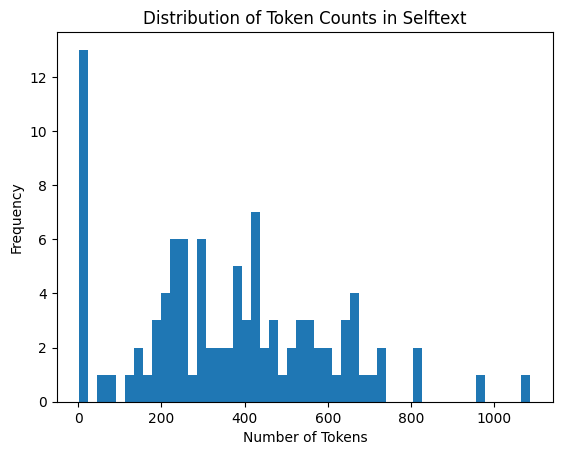

In [ ]:
data_subset["token_count"] = data_subset["selftext_preprocessed"].apply(len)
plt.hist(data_subset["token_count"], bins=50)
plt.title("Distribution of Token Counts in Selftext")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.show()

In [ ]:
data["link_flair_text"].unique()

In [18]:
asshole_flairs = ["asshole", 
                  "slight asshole",
                  "Asshole", 
                  "asshole (a bit)", 
                  "Asshole (but funny/justified)", 
                  "justified asshole",
                  "huge asshole", 
                  "asshole (Kind of)",
                  "asshole (tiny bit)", 
                  "Crouching Liar; hidden asshole",
                  "Not the A-hole POO Mode",
                  "Asshole POO Mode"]
data["target"] = data["link_flair_text"].apply(lambda x: 1 if x in asshole_flairs else 0)

In [19]:
documents = data["selftext_preprocessed"].tolist()
titles = data["title"].tolist()
tfidfvectorizer = TfidfVectorizer(stop_words="english")
countvectorizer = TfidfVectorizer(stop_words="english", use_idf=False, norm=None)

tfidf = tfidfvectorizer.fit_transform(raw_documents=documents)
tfidf_df = pd.DataFrame(tfidf.todense(), index=titles, columns=tfidfvectorizer.get_feature_names_out())

absolute_tfidf = countvectorizer.fit_transform(raw_documents=documents)
absolute_tfidf_df = pd.DataFrame(absolute_tfidf.todense(), index=titles, columns=countvectorizer.get_feature_names_out())


In [20]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_df, data["target"], test_size=0.2, random_state=42)

In [25]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
print(classification_report(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.99      0.88      3136
           1       0.53      0.02      0.05       863

    accuracy                           0.78      3999
   macro avg       0.66      0.51      0.46      3999
weighted avg       0.73      0.78      0.70      3999

F1 Score: 0.046511627906976744
